# 1. SETUP & IMPORT LIBRARIES

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from wordcloud import WordCloud
import numpy as np
import os

## Konfigurasi Visualisasi

In [2]:
sns.set_palette("viridis")
sns.set_style("whitegrid")
plt.rcParams.update({'figure.dpi': 120})

## Stopwords Simple

In [3]:
STOPWORDS_ID = set([
    'di', 'ke', 'dari', 'dan', 'ini', 'itu', 'yang', 'untuk', 'dengan',
    'saja', 'tidak', 'tapi', 'ada', 'bisa', 'karena', 'yg', 'gak', 'ga',
    'aja', 'juga', 'akan', 'pada', 'sih', 'kok', 'deh', 'ya',
    'adalah', 'sebagai', 'merupakan', 'saya', 'kamu', 'mereka',
])

# 2. HELPER FUNCTIONS

In [4]:
def find_hashtags(tweet):
    """Mengekstrak hashtag (#)"""
    return re.findall(r"#(\w+)", str(tweet))

def find_mentions(tweet):
    """Mengekstrak mention (@)"""
    return re.findall(r"@(\w+)", str(tweet))

def find_uppercase_words(tweet):
    """Mengekstrak kata yang ditulis full kapital (min. 2 huruf)"""
    return re.findall(r'\b[A-Z]{2,}\b', str(tweet))

def find_urls(tweet):
    """Mengekstrak URL"""
    return re.findall(r'http\S+|www\.\S+', str(tweet))

def clean_for_wordcloud(text):
    """Pembersihan minimal untuk visualisasi (hapus mention, hashtag, URL)"""
    text = str(text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    return text.lower()

def get_top_n_items(df_subset, col, n=5, prefix=''):
    """Helper untuk mengambil Top N item dari kolom bertipe list"""
    all_items = [it.lower() for sub in df_subset[col] for it in sub]
    if not all_items: return pd.DataFrame({'Item': [f"{prefix}N/A"], 'Count': [0]})
    c = Counter(all_items)
    items, counts = zip(*c.most_common(n))
    return pd.DataFrame({'Item': [f"{prefix}{i}" for i in items], 'Count': counts})

# 3. DATA LOADING & FEATURE ENGINEERING

In [ ]:
file_path = "tweet_bersih.csv"
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"ERROR: File tidak ditemukan di {file_path}.")
    exit()

print("--- Data Loading & Feature Engineering Dimulai ---")
# Pembersihan Awal & Konsistensi
df['sentimen'] = df['sentimen'].astype(str).str.lower()
df['tweet_bersih'] = df['tweet_bersih'].astype(str)

# Ekstraksi Fitur
df['panjang_tweet'] = df['tweet_bersih'].str.len()
df['hashtags'] = df['tweet_bersih'].apply(find_hashtags)
df['mentions'] = df['tweet_bersih'].apply(find_mentions)
df['uppercase_words'] = df['tweet_bersih'].apply(find_uppercase_words)
df['urls'] = df['tweet_bersih'].apply(find_urls)
df['jumlah_seru'] = df['tweet_bersih'].str.count(r'!')
df['jumlah_tanya'] = df['tweet_bersih'].str.count(r'\?')
df['tweet_bersih'] = df['tweet_bersih'].apply(clean_for_wordcloud)

# Feature Biner (Untuk Analisis Persentase)
df['has_hashtag'] = df['hashtags'].apply(lambda x: 1 if len(x) > 0 else 0)
df['has_mention'] = df['mentions'].apply(lambda x: 1 if len(x) > 0 else 0)
df['has_url'] = df['urls'].apply(lambda x: 1 if len(x) > 0 else 0)
print("--- Feature Engineering Selesai. Data Siap Analisis. ---\n")

--- Data Loading & Feature Engineering Dimulai ---
--- Feature Engineering Selesai. Data Siap Analisis. ---



# 4. EXPLORATORY DATA ANALYSIS (EDA) & VISUALISASI

## 4.1. Analisis Distribusi Sentimen (Data Balancing)

4.1. DISTRIBUSI SENTIMEN (DATA BALANCING)
Persentase Distribusi Sentimen:
 sentimen
positif    33.72%
netral     33.44%
negatif    32.84%
Name: count, dtype: object


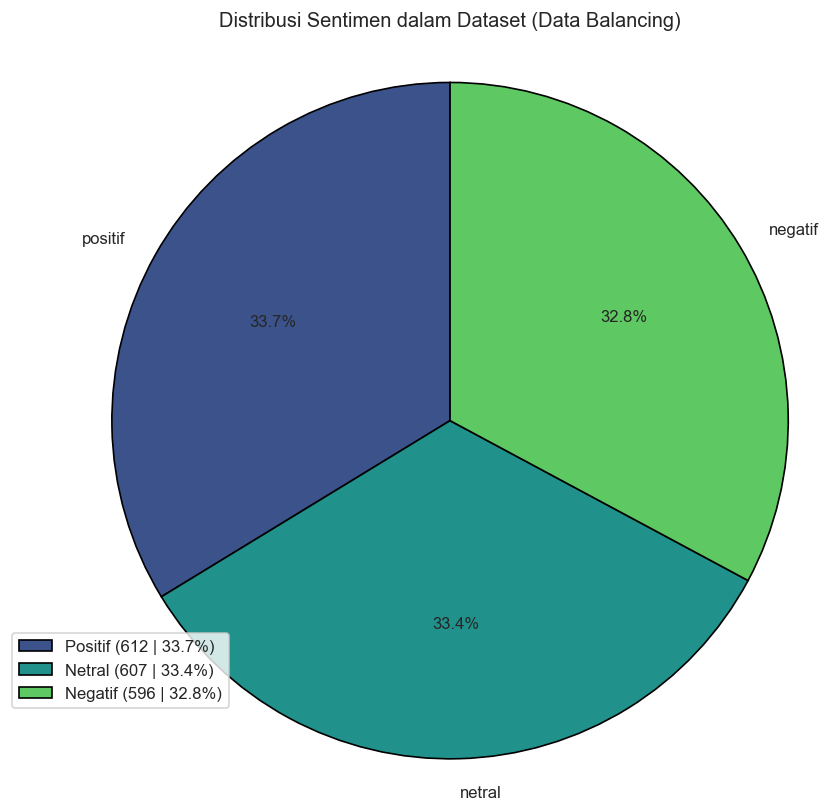

In [6]:
print("="*80); print("4.1. DISTRIBUSI SENTIMEN (DATA BALANCING)"); print("="*80)
sentiment_counts = df['sentimen'].value_counts()
total_tweets = len(df)
sentiment_percentage = (sentiment_counts / total_tweets) * 100
print("Persentase Distribusi Sentimen:\n", sentiment_percentage.round(2).astype(str) + '%')

plt.figure(figsize=(8, 8)) # Menggunakan rasio 1:1 agar Pie Chart berbentuk lingkaran sempurna

# Membuat label untuk Pie Chart: menggabungkan sentimen, jumlah, dan persentase
pie_labels = [f'{s.capitalize()} ({c} | {p:.1f}%)'
              for s, c, p in zip(
                  sentiment_counts.index, 
                  sentiment_counts.values, 
                  sentiment_percentage.values
              )]

# Membuat Pie Chart
plt.pie(
    sentiment_counts.values,
    labels=sentiment_counts.index, # Hanya menggunakan nama sentimen sebagai label di chart
    autopct='%1.1f%%', # Menampilkan persentase dengan 1 angka di belakang koma
    startangle=90,     # Memulai potongan pertama dari atas (pukul 12)
    colors=sns.color_palette("viridis", len(sentiment_counts)), # Menggunakan palet yang sama
    wedgeprops={"edgecolor": "black", 'linewidth': 1} # Menambahkan garis tepi agar lebih rapi
)

# Menambahkan legenda terpisah yang lebih informatif
plt.legend(
    loc='lower left', 
    labels=pie_labels, 
    fontsize=10, 
    bbox_to_anchor=(-0.1, 0.1) # Memposisikan legenda di luar plot
)

plt.title('Distribusi Sentimen dalam Dataset (Data Balancing)', y=1.02) 
plt.axis('equal') # Memastikan Pie Chart berbentuk lingkaran
plt.show()

## 4.2. Analisis Linguistik: Panjang Tweet

4.2. PANJANG TWEET PER SENTIMEN
Statistik Panjang Tweet per Sentimen:
           count    mean    std   min    25%    50%     75%    max
sentimen                                                         
negatif   596.0  114.53  50.03   9.0  74.00  113.0  154.25  263.0
netral    607.0   88.86  48.48  14.0  50.00   75.0  119.50  237.0
positif   612.0  119.75  48.25  15.0  81.75  119.0  157.25  237.0


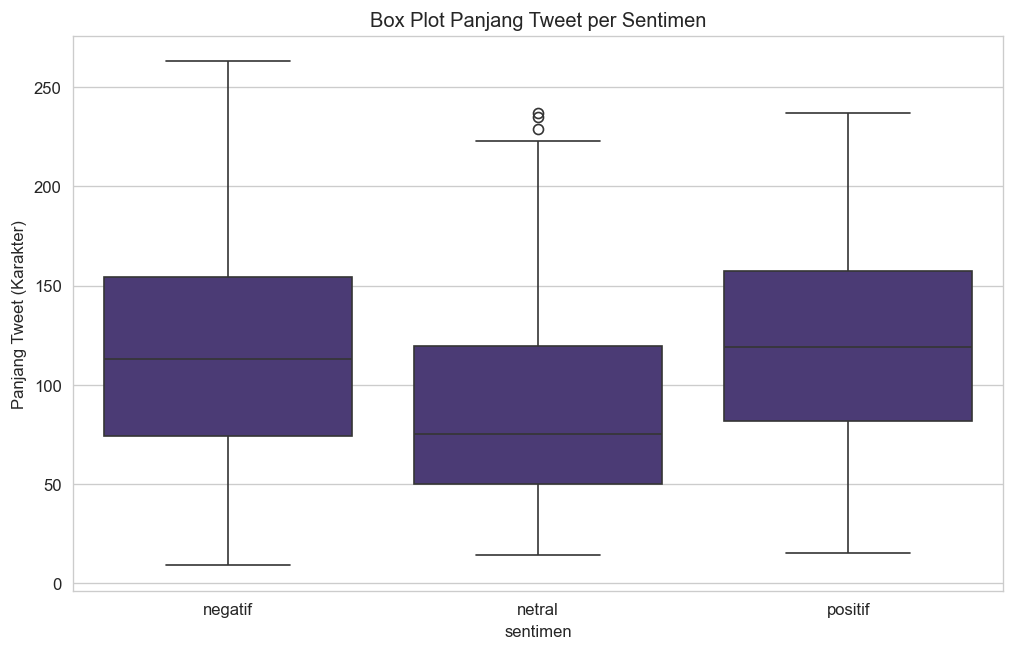

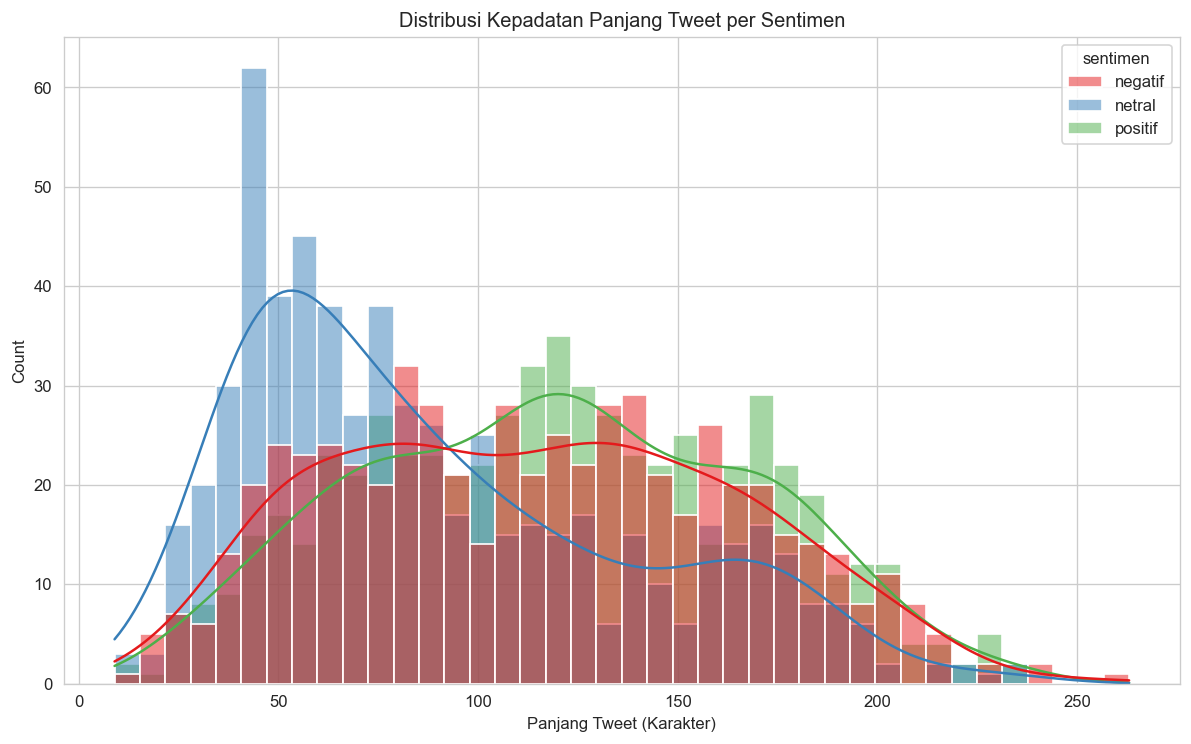

In [7]:
print("="*80); print("4.2. PANJANG TWEET PER SENTIMEN"); print("="*80)
print("Statistik Panjang Tweet per Sentimen:\n", df.groupby('sentimen')['panjang_tweet'].describe().round(2))

plt.figure(figsize=(10, 6)); sns.boxplot(x='sentimen', y='panjang_tweet', data=df)
plt.title('Box Plot Panjang Tweet per Sentimen'); plt.ylabel('Panjang Tweet (Karakter)'); plt.show()
plt.figure(figsize=(12, 7)); sns.histplot(data=df, x='panjang_tweet', hue='sentimen', kde=True, bins=40, palette='Set1')
plt.title('Distribusi Kepadatan Panjang Tweet per Sentimen'); plt.xlabel('Panjang Tweet (Karakter)'); plt.show()